In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import scipy.cluster.hierarchy as sch
from scipy.sparse import dia_matrix
from scipy.optimize import curve_fit

In [3]:
from IPython.display import display, HTML

In [4]:
import context
from hier_clust import linkage_util, HierClust
from hier_clust.tree_util import Tree

In [5]:
from gen_data_util import gen_data, plot_tree_overlay
from time_util import TimingRegistry

In [6]:
import logging
logging.basicConfig(level = logging.INFO)

In [7]:
def analysis(depth, k = None, seed = None, run_top_down = True, run_bottom_up = True):
    reg = TimingRegistry()

    if seed is not None:
        np.random.seed(seed)

    n_obs = 2 ** depth
    n_dim = 10

    if k is None:
        k = int(max(n_obs * 0.1, 2))
    elif callable(k):
        k = k(n_obs)

    print("depth = {}, n_obs = {}, k = {}".format(depth, n_obs, k))

    with reg.timer("generate data") as timer:
        x, y = gen_data(depth = depth, n_dim = n_dim, depth_labels = 3)

    indices = np.arange(n_obs)
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]

    assert x.shape == (n_obs, n_dim)
    assert y.shape == (n_obs,)

    if run_top_down:
        hc = HierClust(n_neighbors=k, neighbor_graph_strategy='balltree')

        with reg.timer("distances") as timer:
            dist = hc._get_distances(x)
        with reg.timer("connected components") as timer:
            components = hc._get_connected_components(dist)
        with reg.timer("similarity") as timer:
            similarity = hc._get_similarity(dist)
        with reg.timer("compute laplacian") as timer:
            diag = similarity.sum(axis = 0)
            diag = dia_matrix((diag, [0]), (n_obs, n_obs)).tocsr()
            laplacian = diag - similarity
        with reg.timer("get_fiedler_vector") as timer:
            fiedler_vector = hc._get_fiedler_vector(laplacian)

        with reg.timer("fit") as timer:
            fit_result = hc.fit(x)

    if run_bottom_up:
        with reg.timer("complete linkage") as timer:
            link = sch.linkage(x, method='complete')
        with reg.timer("convert linkage to tree") as timer:
            t = linkage_util.linkage_to_tree(link)

    cols = ["n_obs", "k"]
    row = [n_obs, k]
    for key, val in reg.registry.items():
        cols.append(key)
        row.append(val)
    row = pd.Series(row, index = cols)
    
    return row

In [8]:
rows = []

In [9]:
%%time
for depth in range(7, 10 + 1):
    row = analysis(depth = depth, k = 100, seed = 1)
    rows.append(row)

depth = 7, n_obs = 128, k = 100
Elapsed time: 0.009 seconds (generate data)
Elapsed time: 0.040 seconds (distances)
Elapsed time: 0.016 seconds (connected components)
Elapsed time: 0.003 seconds (similarity)
Elapsed time: 0.001 seconds (compute laplacian)
Elapsed time: 0.006 seconds (get_fiedler_vector)
Elapsed time: 0.611 seconds (fit)
Elapsed time: 0.000 seconds (complete linkage)
Elapsed time: 0.001 seconds (convert linkage to tree)
depth = 8, n_obs = 256, k = 100
Elapsed time: 0.009 seconds (generate data)
Elapsed time: 0.104 seconds (distances)
Elapsed time: 0.034 seconds (connected components)
Elapsed time: 0.004 seconds (similarity)
Elapsed time: 0.001 seconds (compute laplacian)
Elapsed time: 0.009 seconds (get_fiedler_vector)


INFO:hier_clust.hier_clust:Found 2 components at tree_path ''


Elapsed time: 1.260 seconds (fit)
Elapsed time: 0.001 seconds (complete linkage)
Elapsed time: 0.002 seconds (convert linkage to tree)
depth = 9, n_obs = 512, k = 100
Elapsed time: 0.017 seconds (generate data)
Elapsed time: 0.206 seconds (distances)
Elapsed time: 0.072 seconds (connected components)
Elapsed time: 0.008 seconds (similarity)
Elapsed time: 0.001 seconds (compute laplacian)
Elapsed time: 0.015 seconds (get_fiedler_vector)


INFO:hier_clust.hier_clust:Found 4 components at tree_path ''


Elapsed time: 2.536 seconds (fit)
Elapsed time: 0.004 seconds (complete linkage)
Elapsed time: 0.005 seconds (convert linkage to tree)
depth = 10, n_obs = 1024, k = 100
Elapsed time: 0.035 seconds (generate data)
Elapsed time: 0.464 seconds (distances)
Elapsed time: 0.144 seconds (connected components)
Elapsed time: 0.016 seconds (similarity)
Elapsed time: 0.001 seconds (compute laplacian)
Elapsed time: 0.027 seconds (get_fiedler_vector)


INFO:hier_clust.hier_clust:Found 8 components at tree_path ''


Elapsed time: 5.118 seconds (fit)
Elapsed time: 0.018 seconds (complete linkage)
Elapsed time: 0.010 seconds (convert linkage to tree)
CPU times: user 10.7 s, sys: 181 ms, total: 10.9 s
Wall time: 10.8 s


In [10]:
# row = analysis(depth = 16, k = 100, seed = 1, run_bottom_up = False)
# rows.append(row)

In [11]:
# row = analysis(depth = 17, k = 100, seed = 1, run_bottom_up = False)
# rows.append(row)

In [12]:
# row = analysis(depth = 18, k = 100, seed = 1, run_bottom_up = False)
# rows.append(row)

In [13]:
# row = analysis(depth = 16, k = 100, seed = 1, run_top_down = False)
# rows.append(row)

In [14]:
summary = pd.DataFrame.from_records(rows)
summary = summary.loc[:, rows[0].index]
display(HTML(summary.to_html(index = False)))

n_obs,k,generate data,distances,connected components,similarity,compute laplacian,get_fiedler_vector,fit,complete linkage,convert linkage to tree
128.0,100.0,0.008750,0.039683,0.015886,0.002615,0.000572,0.006380,0.610630,0.000488,0.001213
256.0,100.0,0.008742,0.103914,0.033590,0.004107,0.000615,0.009180,1.260217,0.001190,0.002372
512.0,100.0,0.017477,0.206410,0.071920,0.007798,0.001073,0.014847,2.535839,0.004280,0.005127
1024.0,100.0,0.035000,0.464281,0.143619,0.016258,0.001319,0.026848,5.118453,0.018276,0.009870


In [15]:
# summary = pd.read_csv('/Users/aleverentz/Desktop/temp_stats_for_plotting.csv')

In [16]:
def power_law(x, offset, coeff, exponent):
    return offset + coeff * x ** exponent

In [17]:
mask = np.isfinite(summary["fit"])
linear_scaling = lambda x, coeff: power_law(x, offset = 0, coeff = coeff, exponent = 1.0)
c1, _ = curve_fit(linear_scaling, summary["n_obs"][mask], summary["fit"][mask])
mask = np.isfinite(summary["complete linkage"])
quad_scaling = lambda x, coeff: power_law(x, offset = 0, coeff = coeff, exponent = 2.0)
c2, _ = curve_fit(quad_scaling, summary["n_obs"][mask], summary["complete linkage"][mask])
c1, c2

(array([ 0.00498364]), array([  1.73702472e-08]))

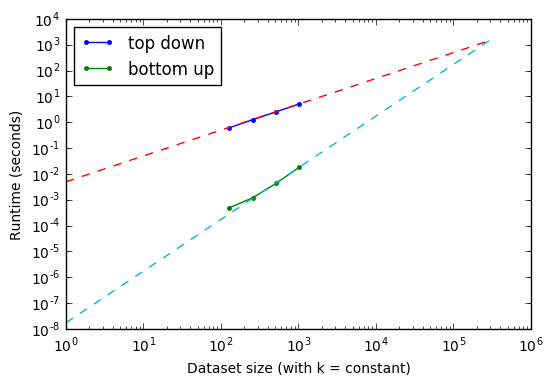

In [18]:
fig, ax = plt.subplots()
ax.loglog(summary["n_obs"], summary["fit"], label = "top down", marker='.')
ax.loglog(summary["n_obs"], summary["complete linkage"], label = "bottom up", marker='.')

def show_scaling(x_range, exponent, coeff, offset, ax, **kwargs):
    x = np.logspace(np.log10(x_range[0]), np.log10(x_range[1]))
    ax.plot(x, offset + coeff * x ** exponent, linestyle='--', **kwargs)

show_scaling(x_range = (1, 3e5), offset = 0, coeff = c1[0], exponent = 1.0, ax = ax)
show_scaling(x_range = (1, 3e5), offset = 0, coeff = c2[0], exponent = 2.0, ax = ax)

ax.set_ylabel('Runtime (seconds)')
ax.set_xlabel('Dataset size (with k = constant)')
ax.legend(loc='best')

None

In [19]:
# fig, ax = plt.subplots()
# for yi in np.unique(y):
#     ax.plot(x[y == yi, 0], x[y == yi, 1], '.')
# plot_tree_overlay(data = x, tree = fit_result[0], max_depth = 10, ax = ax)

# None

##### Cleanup

In [20]:
plt.close()